In [1]:
!pip install seaborn

In [2]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.applications.mobilenet_v2 import MobileNetV2

from IPython.display import HTML
from base64 import b64encode


2025-05-23 13:52:05.886031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748008326.165304    6841 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748008326.243186    6841 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
NonViolenceVideos_Dir = "/kaggle/input/violence-nonviolence/Real_Life_Violence_Dataset/NonViolence"
ViolenceVideos_Dir = "/kaggle/input/violence-nonviolence/Real_Life_Violence_Dataset/Violence"

In [5]:
NonViolence_files_names_list = os.listdir(NonViolenceVideos_Dir)
Violence_files_names_list = os.listdir(ViolenceVideos_Dir)

In [6]:
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
print(Random_NonViolence_Video)
Random_Violence_Video = random.choice(Violence_files_names_list)

NV_986.mp4


In [7]:
IMAGE_HEIGHT,IMAGE_WIDTH=100,100
SEQUENCE_LENGTH = 16

In [8]:
DATASET_DIR = "/kaggle/input/violence-nonviolence/Real_Life_Violence_Dataset"

In [9]:
CLASSES_LIST = ["NonViolence", "Violence"]

In [10]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

### Creating dataset for 500 videos of each class

In [11]:
import os
import numpy as np

def create_dataset(max_videos_per_class=750):
    features = []
    labels = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        count = 0
        for file_name in files_list:
            if count >= max_videos_per_class:
                break  
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                count += 1  

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels

In [12]:
features, labels = create_dataset()

Extracting Data of Class: NonViolence


[h264 @ 0x772a5580] mb_type 104 in P slice too large at 98 31
[h264 @ 0x772a5580] error while decoding MB 98 31
[h264 @ 0x772a5580] mb_type 104 in P slice too large at 98 31
[h264 @ 0x772a5580] error while decoding MB 98 31
[h264 @ 0x772a5580] mb_type 104 in P slice too large at 98 31
[h264 @ 0x772a5580] error while decoding MB 98 31
[h264 @ 0x772a5580] mb_type 104 in P slice too large at 98 31
[h264 @ 0x772a5580] error while decoding MB 98 31


Extracting Data of Class: Violence


In [13]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.1,
                                                                            shuffle=True, random_state=42)

In [14]:
print(features_train.shape, labels_train.shape)
print(features_test.shape, labels_test.shape)

(1350, 16, 100, 100, 3) (1350, 2)
(150, 16, 100, 100, 3) (150, 2)


In [15]:
mobilenet = MobileNetV2(include_top=False, weights="imagenet")
mobilenet.trainable = True

/tmp/ipykernel_6841/2113161707.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights="imagenet")
I0000 00:00:1748009259.112865    6841 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748009259.113705    6841 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [16]:
for layer in mobilenet.layers[:-20]:
    layer.trainable = False

In [17]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(mobilenet))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards=True)
    model.add(Bidirectional(lstm_fw, backward_layer=lstm_bw))

    model.add(Dropout(0.35))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    

    model.summary()
    return model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 16, 3, 3, 1280)      │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 3, 3, 1280)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 16, 11520)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │       2,957,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,275,986 (20.13 MB)

 Trainable params: 4,224,082 (16.11 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

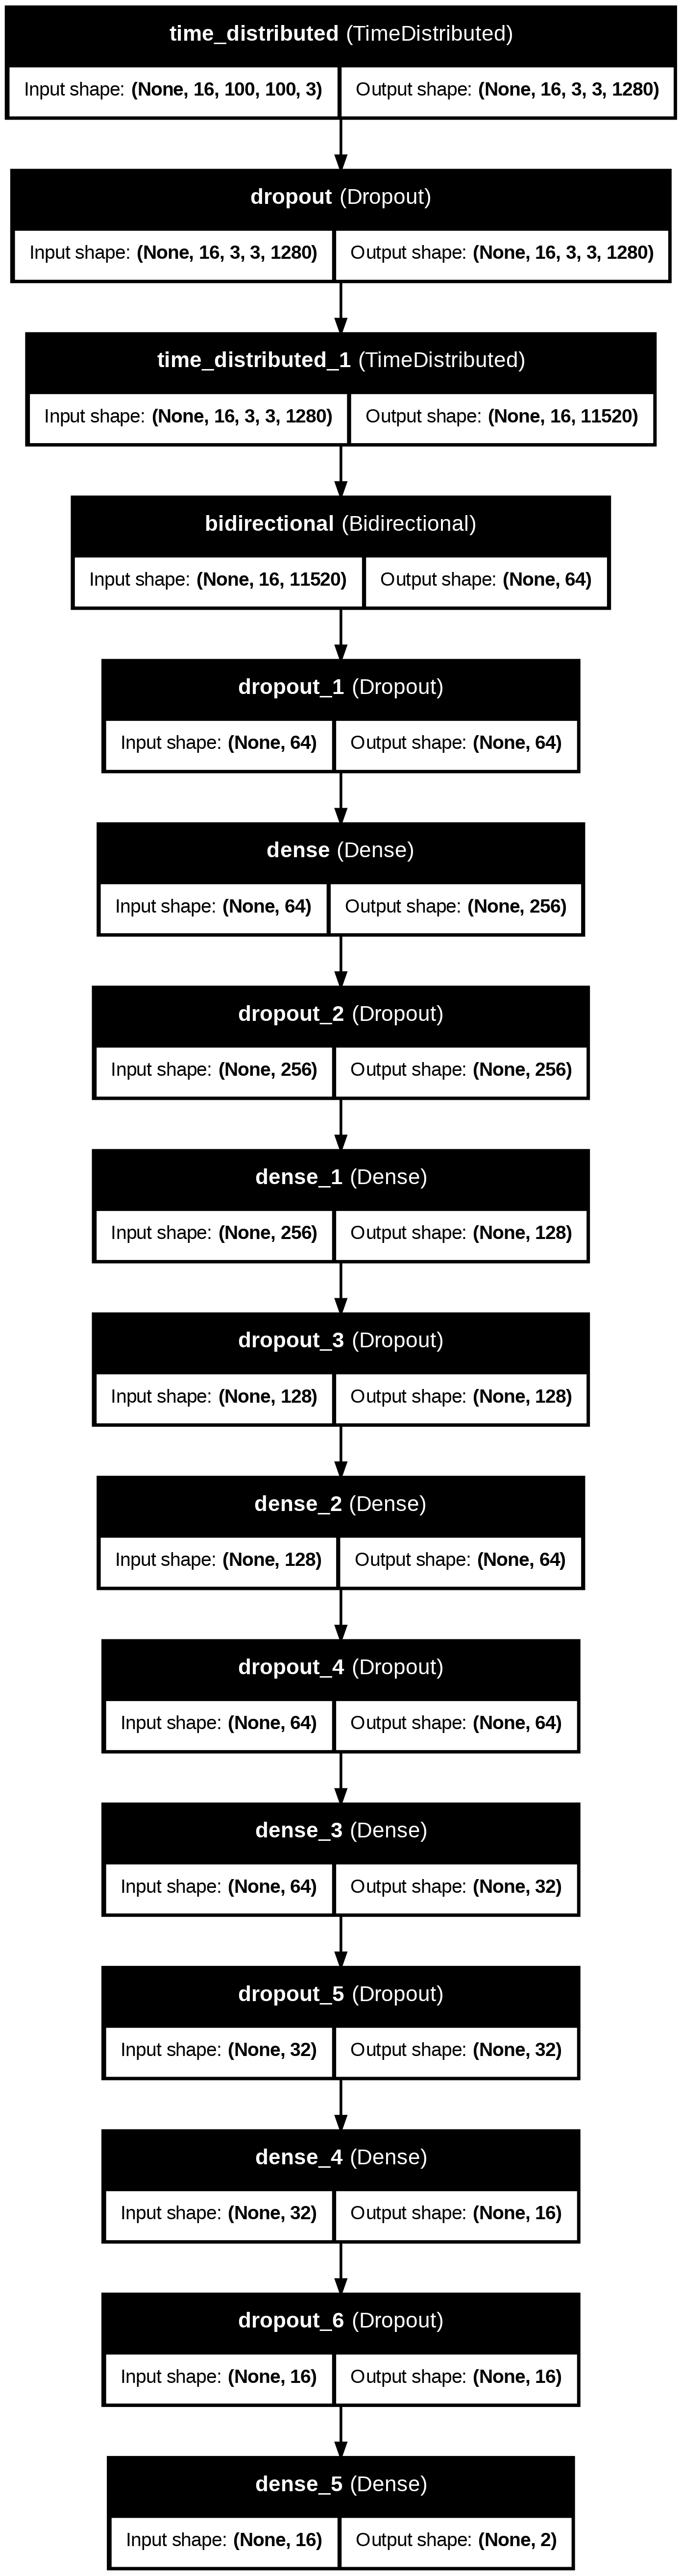

In [18]:
MoBiLSTM_model = create_model()
plot_model(MoBiLSTM_model, to_file='MobBiLSTM_model_structure_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=10, min_lr=0.00005, verbose=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Mobile_LSTM.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    save_weights_only=False, 
    verbose=1
)

In [20]:
MoBiLSTM_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])
MobBiLSTM_model_history = MoBiLSTM_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=8,
                                             shuffle=True, validation_split=0.2,
                                             callbacks=[reduce_lr, checkpoint_callback])


Epoch 1/50


I0000 00:00:1748009382.645457   12884 cuda_dnn.cc:529] Loaded cuDNN version 90300


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.4994 - loss: 0.7106
Epoch 1: val_accuracy improved from -inf to 0.46296, saving model to Mobile_LSTM.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 167s 382ms/step - accuracy: 0.4994 - loss: 0.7106 - val_accuracy: 0.4630 - val_loss: 0.6949 - learning_rate: 0.0100
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5009 - loss: 0.6996
Epoch 2: val_accuracy improved from 0.46296 to 0.48519, saving model to Mobile_LSTM.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.5009 - loss: 0.6996 - val_accuracy: 0.4852 - val_loss: 0.6944 - learning_rate: 0.0100
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5094 - loss: 0.6955
Epoch 3: val_accuracy did not improve from 0.48519
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.5095 - loss: 0.6955 - val_accuracy: 0.4667 - val_loss: 0.6943 - learning_rate: 0.0100
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5371 - loss: 0.688

In [21]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

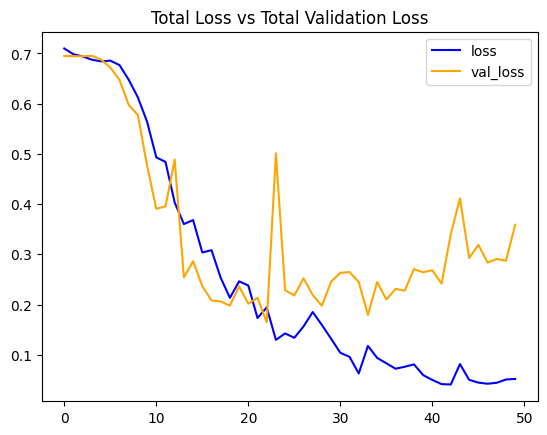

In [28]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

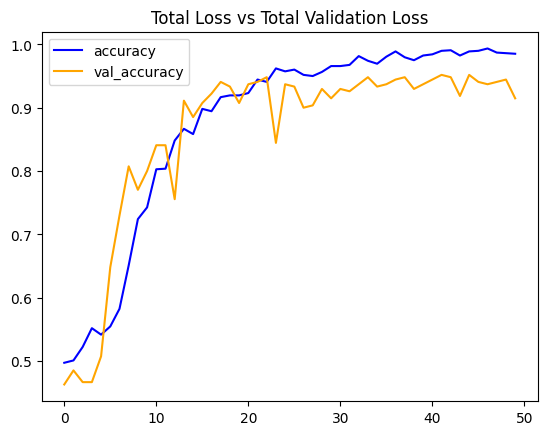

In [29]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [30]:
labels_predict = MoBiLSTM_model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(labels_test, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


In [31]:
from sklearn.metrics import accuracy_score

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.96


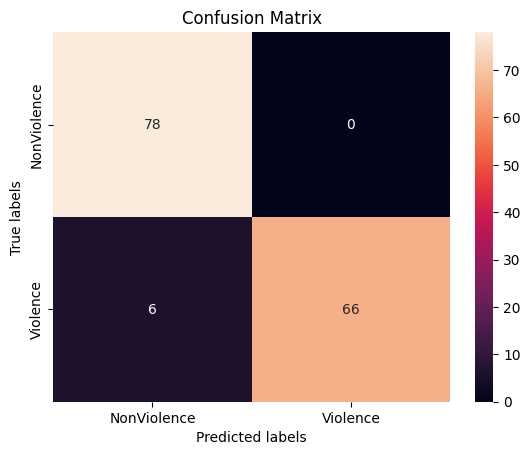

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['NonViolence', 'Violence'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])

plt.savefig('/kaggle/working/confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

In [33]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal, labels_predict)
print('Classification Report is : \n', ClassificationReport)


Classification Report is : 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        78
           1       1.00      0.92      0.96        72

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



In [27]:
MoBiLSTM_model.save('Mobile_LSTM_final.keras')

In [ ]:
MoBiLSTM_model.save_weights('Modile_LSTM_final.h5')